In [ ]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from torch_niff.resnet_niff_splitconv import resnet50

## Initialize input feature maps for NIFF

In [ ]:
# Auto-detect best available device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
print(f"Using device: {device}")

imageheight = 56
imagewidth = 56

mask56 = torch.cat([
            torch.arange(-(imageheight/2), (imageheight/2), requires_grad=True)[None, :].repeat(imagewidth, 1).unsqueeze(0),
            torch.arange(-(imagewidth/2), (imagewidth/2), requires_grad=True)[:, None].repeat(1, imagewidth).unsqueeze(0)], dim=0).to(device)

imageheight = 28
imagewidth = 28

mask28 = torch.cat([
            torch.arange(-(imageheight/2), (imageheight/2), requires_grad=True)[None, :].repeat(imagewidth, 1).unsqueeze(0),
            torch.arange(-(imagewidth/2), (imagewidth/2), requires_grad=True)[:, None].repeat(1, imagewidth).unsqueeze(0)], dim=0).to(device)


imageheight = 14
imagewidth = 14

mask14 = torch.cat([
            torch.arange(-(imageheight/2), (imageheight/2), requires_grad=True)[None, :].repeat(imagewidth, 1).unsqueeze(0),
            torch.arange(-(imagewidth/2), (imagewidth/2), requires_grad=True)[:, None].repeat(1, imagewidth).unsqueeze(0)], dim=0).to(device)


## PCA for each layer in the actual resolution of the layer

Load state_dict by model_key = model


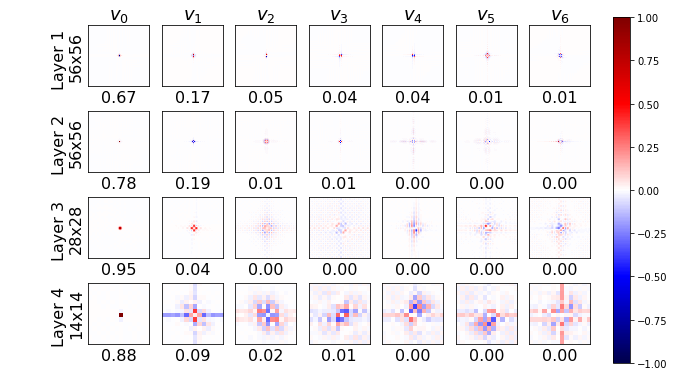

In [ ]:
# Auto-detect best available device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
print(f"Using device: {device}")

# load model and model weights
model = resnet50(num_classes=1000)
path = "/checkpoint-best.pth" #path to model weights
model.load_state_dict(path)

    
model = model.to(device)
model.eval()


# iterate over each layer to get the weights of our NIFF
# for each layer select NIFF for the real and imaginary part
# feed each NIFF with the corresponding input feature maps
# and combine real and imaginary part
# afterwards tranformation back into the spatial domain via IFFT
k = None
ies = [1,2]

for i in ies:
    partmodel_imag = model.layer1[i].conv2[0].mlp_imag
    partmodel_real = model.layer1[i].conv2[0].mlp_real

    treal = partmodel_real(mask56)
    timag = partmodel_imag(mask56)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

l1k = k.cpu().detach().numpy()

# PCA on the spatial kernel weights of our NIFF
l1data_2d = np.array([features_2d.flatten() for features_2d in l1k])
l1pca = PCA(n_components=7)
l1dX_n = l1pca.fit_transform(l1data_2d)


k = None
ies = [1,2,3]

for i in ies:
    partmodel_imag = model.layer2[i].conv2[0].mlp_imag
    partmodel_real = model.layer2[i].conv2[0].mlp_real

    treal = partmodel_real(mask56)
    timag = partmodel_imag(mask56)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

l2k = k.cpu().detach().numpy()

l2data_2d = np.array([features_2d.flatten() for features_2d in l2k])
l2pca = PCA(n_components=7)
l2dX_n = l2pca.fit_transform(l2data_2d)


k = None
ies = [1,2,3,4,5]

for i in ies:
    partmodel_imag = model.layer3[i].conv2[0].mlp_imag
    partmodel_real = model.layer3[i].conv2[0].mlp_real

    treal = partmodel_real(mask28)
    timag = partmodel_imag(mask28)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

l3k = k.cpu().detach().numpy()

l3data_2d = np.array([features_2d.flatten() for features_2d in l3k])
l3pca = PCA(n_components=7)
l3dX_n = l3pca.fit_transform(l3data_2d)


k = None
ies = [1,2]

for i in ies:
    partmodel_imag = model.layer4[i].conv2[0].mlp_imag
    partmodel_real = model.layer4[i].conv2[0].mlp_real

    treal = partmodel_real(mask14)
    timag = partmodel_imag(mask14)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

l4k = k.cpu().detach().numpy()

l4data_2d = np.array([features_2d.flatten() for features_2d in l4k])
l4pca = PCA(n_components=7)
l4dX_n = l4pca.fit_transform(l4data_2d)


# visualization of the PCA of the spatial kernel weights

gridspec = dict(hspace=0.0, height_ratios=[1, 0.25 ,1, 0.25, 1, 0.25, 1])
fig, axes = plt.subplots(7, 7, figsize=(9, 6), gridspec_kw=gridspec)
for j, ho in enumerate(axes):
    for i, ax in enumerate(ho):
        if j == 0:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            im = ax.imshow(l1pca.components_[i].reshape(56, 56), vmin=-1, vmax=1, cmap="seismic")
            ax.set_title(f"$v_{i}$", fontweight='bold', fontsize=18)
            ax.set_xlabel(f"{l1pca.explained_variance_ratio_[i]:.2f}", fontsize=16)
            if i == 0:
                ax.set_ylabel(f'Layer 1 \n56x56', fontsize=16)
        if j == 1 or j == 3 or j == 5:
            ax.set_visible(False)
        if j == 2:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            im = ax.imshow(l2pca.components_[i].reshape(56, 56), vmin=-1, vmax=1, cmap="seismic")
            ax.set_xlabel(f"{l2pca.explained_variance_ratio_[i]:.2f}", fontsize=16)
            if i == 0:
                ax.set_ylabel(f'Layer 2 \n56x56', fontsize=16)
        if j == 4:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            im = ax.imshow(l3pca.components_[i].reshape(28, 28), vmin=-1, vmax=1, cmap="seismic")
            ax.set_xlabel(f"{l3pca.explained_variance_ratio_[i]:.2f}", fontsize=16)
            if i == 0:
                ax.set_ylabel(f'Layer 3 \n28x28', fontsize=16)
        if j == 6:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            im = ax.imshow(l4pca.components_[i].reshape(14, 14), vmin=-1, vmax=1, cmap="seismic")
            ax.set_xlabel(f"{l4pca.explained_variance_ratio_[i]:.2f}", fontsize=16)
            if i == 0:
                ax.set_ylabel(f'Layer 4 \n14x14', fontsize=16)

# set shared colorbar                
cb_ax = fig.add_axes([0, 0.09, 1.1, 0.8])    
cb_ax.axis("off")
fig.colorbar(im, ax=cb_ax)


## PCA for each layer zoomed in to 9x9

Load state_dict by model_key = model


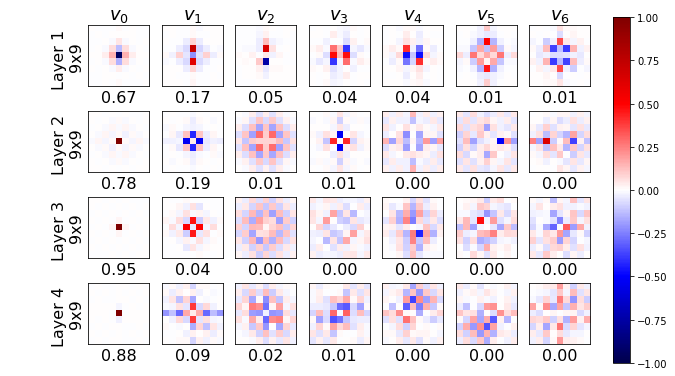

In [2]:
k = None
ies = [1,2]

for i in ies:
    partmodel_imag = model.layer1[i].conv2[0].mlp_imag
    partmodel_real = model.layer1[i].conv2[0].mlp_real

    treal = partmodel_real(mask56)
    timag = partmodel_imag(mask56)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

l1k = k.cpu().detach().numpy()

l1data_2d = np.array([features_2d.flatten() for features_2d in l1k])
l1pca = PCA(n_components=7)
l1dX_n = l1pca.fit_transform(l1data_2d)


k = None
ies = [1,2,3]

for i in ies:
    partmodel_imag = model.layer2[i].conv2[0].mlp_imag
    partmodel_real = model.layer2[i].conv2[0].mlp_real

    treal = partmodel_real(mask56)
    timag = partmodel_imag(mask56)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

l2k = k.cpu().detach().numpy()

l2data_2d = np.array([features_2d.flatten() for features_2d in l2k])
l2pca = PCA(n_components=7)
l2dX_n = l2pca.fit_transform(l2data_2d)


k = None
ies = [1,2,3,4,5]

for i in ies:
    partmodel_imag = model.layer3[i].conv2[0].mlp_imag
    partmodel_real = model.layer3[i].conv2[0].mlp_real

    treal = partmodel_real(mask28)
    timag = partmodel_imag(mask28)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

l3k = k.cpu().detach().numpy()

l3data_2d = np.array([features_2d.flatten() for features_2d in l3k])
l3pca = PCA(n_components=7)
l3dX_n = l3pca.fit_transform(l3data_2d)


k = None
ies = [1,2]

for i in ies:
    partmodel_imag = model.layer4[i].conv2[0].mlp_imag
    partmodel_real = model.layer4[i].conv2[0].mlp_real

    treal = partmodel_real(mask14)
    timag = partmodel_imag(mask14)

    t = torch.fft.ifftshift(torch.fft.ifft2(torch.complex(treal, timag))).real[0]
    if k is None:
        k = t
    else:
        k = torch.cat([t,k])

l4k = k.cpu().detach().numpy()

l4data_2d = np.array([features_2d.flatten() for features_2d in l4k])
l4pca = PCA(n_components=7)
l4dX_n = l4pca.fit_transform(l4data_2d)



gridspec = dict(hspace=0.0, height_ratios=[1, 0.25 ,1, 0.25, 1, 0.25, 1])
fig, axes = plt.subplots(7, 7, figsize=(9, 6), gridspec_kw=gridspec)
for j, ho in enumerate(axes):
    for i, ax in enumerate(ho):
        if j == 0:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            # zoom in into 9x9 kernel for better visualization
            im = ax.imshow(l1pca.components_[i].reshape(56, 56)[24:33, 24:33], vmin=-1, vmax=1, cmap="seismic")
            ax.set_title(f"$v_{i}$", fontweight='bold', fontsize=18)
            ax.set_xlabel(f"{l1pca.explained_variance_ratio_[i]:.2f}", fontsize=16)
            if i == 0:
                ax.set_ylabel(f'Layer 1 \n9x9', fontsize=16)
        if j == 1 or j == 3 or j == 5:
            ax.set_visible(False)
        if j == 2:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            im = ax.imshow(l2pca.components_[i].reshape(56, 56)[24:33, 24:33], vmin=-1, vmax=1, cmap="seismic")
            ax.set_xlabel(f"{l2pca.explained_variance_ratio_[i]:.2f}", fontsize=16)
            if i == 0:
                ax.set_ylabel(f'Layer 2 \n9x9', fontsize=16)
        if j == 4:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            im = ax.imshow(l3pca.components_[i].reshape(28, 28)[10:19, 10:19], vmin=-1, vmax=1, cmap="seismic")
            ax.set_xlabel(f"{l3pca.explained_variance_ratio_[i]:.2f}", fontsize=16)
            if i == 0:
                ax.set_ylabel(f'Layer 3 \n9x9', fontsize=16)
        if j == 6:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            im = ax.imshow(l4pca.components_[i].reshape(14, 14)[3:12, 3:12], vmin=-1, vmax=1, cmap="seismic")
            ax.set_xlabel(f"{l4pca.explained_variance_ratio_[i]:.2f}", fontsize=16)
            if i == 0:
                ax.set_ylabel(f'Layer 4 \n9x9', fontsize=16)
    
cb_ax = fig.add_axes([0, 0.09, 1.1, 0.8])    
cb_ax.axis("off")
fig.colorbar(im, ax=cb_ax)
